## Packages Import and global model variable assignment
Also fetch local openAI api key

In [1]:
import pandas as pd
import numpy as np
import os
import openai as ai
import xgboost as xgb
import sklearn as sl


ai.api_key = os.environ.get('AI_API_KEY')

#Global model Parameters
n_obs = 1000
eta = 0.1
max_depth = 3
n_estimators = 500


## Data Download and Cleaning

In [2]:
from functions import downloadData

path = (r'C:\Users\Luke\Downloads\reviews_Electronics_5.json')

data = downloadData(path = path, n = n_obs)

In [3]:
data

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"
...,...,...,...,...,...,...,...,...,...
995,AMGIMGPA34FIZ,9983891212,Victor Kirkpatrick,"[1, 1]",Quality of connection and video seems good wit...,5,"This mini HDMI cable, well, it works",1304035200,"04 29, 2011"
996,A22XH75Z0895RC,9983891212,weave,"[0, 0]",What is there to say? I needed a cable to run...,5,Good cable,1372204800,"06 26, 2013"
997,A2XVGWQZN26LX9,9983891212,William J. Weisensee,"[0, 0]",I can find nothing wrong with this cable. It ...,5,Premium Canon Mini HDMI cable (10 ft),1384560000,"11 16, 2013"
998,A2UFAKH7Y8VH5N,9983891212,WilliWu,"[12, 12]",Works perfectly at 1080p HD and in all other C...,5,Perfect for Canon EOS 7d,1270598400,"04 7, 2010"


In [4]:
from functions import transformData

transformed_data = transformData(data = data)

In [5]:
transformed_data

,overall,helpful_ratio,overall_positive,excellent,good,great,impressive,satisfactory,outstanding,fantastic,...,troublesome,detestable,abominable,repugnant,lamentable,revolting,displeasing,dismaying,termination,apprehensive
0,5,0.00,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0.93,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0.82,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5,0.50,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,5,0.00,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,5,0.00,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,5,0.92,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Modelling

In [6]:
response_var = transformed_data['overall_positive']
predictor_var = transformed_data.drop(['overall_positive', 'overall'], axis = 1)

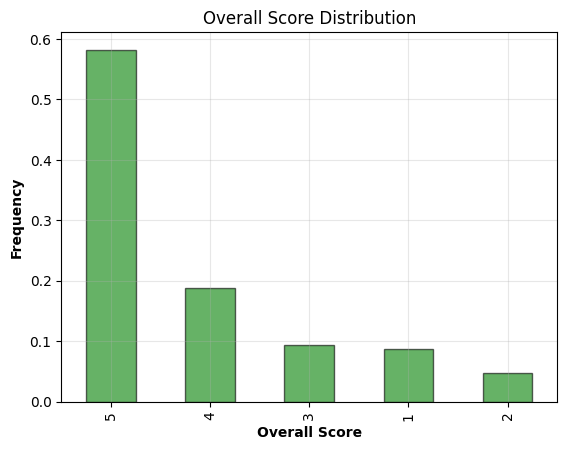

In [7]:
from utils import frequencyHistogram

frequencyHistogram("overall", transformed_data)

In [8]:
predictor_var

,helpful_ratio,excellent,good,great,impressive,satisfactory,outstanding,fantastic,awesome,wonderful,...,troublesome,detestable,abominable,repugnant,lamentable,revolting,displeasing,dismaying,termination,apprehensive
0,0.00,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.75,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.93,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.82,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.50,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0.00,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0.00,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0.92,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(predictor_var, response_var, test_size=0.5, random_state=42)

model = XGBClassifier(objective = 'binary:logistic', eval_metric = 'rmse', n_estimators = n_estimators, learning_rate = eta, max_depth = max_depth)

model.fit(X_train, Y_train)
predictions = model.predict(X_test)


## Model Diagnostics
Here we compare models with diagnositics

In [10]:
from utils import accuracy

accuracy(Y_test, predictions)

Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.29      0.36        63
           1       0.90      0.95      0.93       437

    accuracy                           0.87       500
   macro avg       0.69      0.62      0.64       500
weighted avg       0.85      0.87      0.86       500



In [11]:
from utils import confusionMatrix

confusionMatrix(Y_test, predictions)

Confusion Matrix:

False Positives: 45
False Negatives: 20
True Positives: 417
True Negatives: 18


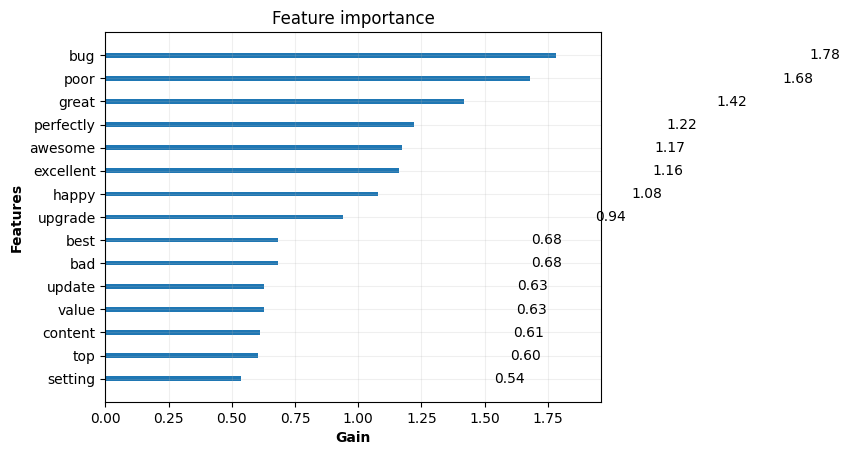

In [12]:
from utils import importance

importance(model)
   